## Just taking a look at the human data

In [1]:
import behav_exp_analysis
df = behav_exp_analysis.data_preprocessing()
df

,Unnamed: 0,sentence_pair,Trial Number,rating,Response,Reaction Time,counterbalance-o1ql,sentence1_model,sentence2_model,sentence1_type,...,sentence1_model_targeted_to_accept,sentence1_model_targeted_to_reject,subject,subject_group,binarized_choice_probability_NC_LB,binarized_choice_probability_NC_UB,majority_vote_NC_LB,majority_vote_NC_UB,mean_rating_NC_LB,mean_rating_NC_UB
0,0,A message has been sent to your account_They a...,66,2.0,Confident,3525.1,set 1_10,all,all,R,...,NaN,NaN,0,1,0.000000,0.0,0.0,0.0,1.333333,1.4
1,1,A road closure is unlikely to impact service_I...,12,3.0,Somewhat confident,7541.2,set 1_10,xlm,trigram,N,...,NaN,NaN,0,1,0.000000,0.0,0.0,0.0,1.666667,1.8
2,2,A whole history of kisses just so right_Our cu...,113,6.0,Very confident,5099.4,set 1_10,xlm,electra,S,...,xlm,electra,0,1,0.888889,0.9,1.0,1.0,4.666667,4.8
3,3,About christmas around thanksgiving was really...,61,4.0,Somewhat confident,5246.1,set 1_10,xlm,bert,S,...,xlm,bert,0,1,0.888889,0.9,1.0,1.0,4.777778,4.7
4,4,After reward yourself with whatever floats you...,159,3.0,Somewhat confident,5246.8,set 1_10,xlm,trigram,N,...,trigram,xlm,0,1,0.222222,0.2,0.0,0.0,2.444444,2.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16495,16495,You can find way better deals than that_You ca...,101,1.0,Very confident,6939.0,set 1_9,roberta,xlm,N,...,NaN,NaN,99,1,0.222222,0.2,0.0,0.0,2.555556,2.4
16496,16496,You definitely have to try these other dessert...,103,1.0,Very confident,11533.0,set 1_9,bigram,roberta,S,...,roberta,bigram,99,1,0.444444,0.4,0.0,0.0,3.333333,3.1
16497,16497,You obviously need to speed someone unless and...,36,4.0,Somewhat confident,10739.0,set 1_9,gpt2,lstm,S,...,lstm,gpt2,99,1,0.888889,0.9,1.0,1.0,5.000000,4.9
16498,16498,You should douse those women before they charg...,82,6.0,Very confident,7674.0,set 1_9,electra,bert,S,...,bert,electra,99,1,1.000000,1.0,1.0,1.0,5.111111,5.2


In [2]:
df.columns

Index(['Unnamed: 0', 'sentence_pair', 'Trial Number', 'rating', 'Response',
       'Reaction Time', 'counterbalance-o1ql', 'sentence1_model',
       'sentence2_model', 'sentence1_type', 'sentence2_type', 'sentence1',
       'sentence2', 'sentence1_gpt2_prob', 'sentence2_gpt2_prob',
       'sentence1_roberta_prob', 'sentence2_roberta_prob',
       'sentence1_electra_prob', 'sentence2_electra_prob',
       'sentence1_bert_prob', 'sentence2_bert_prob', 'sentence1_xlm_prob',
       'sentence2_xlm_prob', 'sentence1_lstm_prob', 'sentence2_lstm_prob',
       'sentence1_rnn_prob', 'sentence2_rnn_prob', 'sentence1_trigram_prob',
       'sentence2_trigram_prob', 'sentence1_bigram_prob',
       'sentence2_bigram_prob', 'sentence1_location', 'trial_type',
       'sentence2_model_targeted_to_accept',
       'sentence2_model_targeted_to_reject',
       'sentence1_model_targeted_to_accept',
       'sentence1_model_targeted_to_reject', 'subject', 'subject_group',
       'binarized_choice_probability_N

<AxesSubplot:>

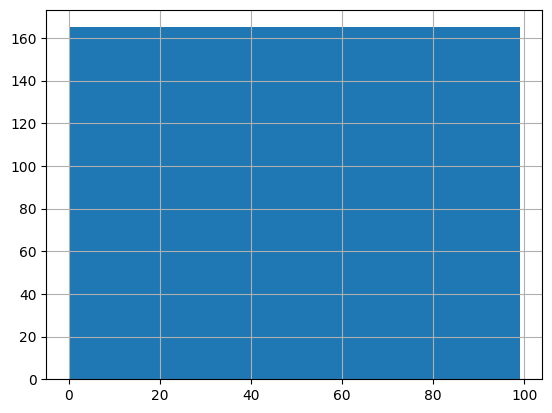

In [3]:
# Number of trials per subject
df.subject.hist(bins =100)

In [4]:
# Sentence1 and sentence2 don't reflect presentation side
df.loc[df['sentence2'] == 'A message has been sent to your account','sentence2'].count()

0

In [6]:
# 100 subjects were matched to 1 of 10 sets of sentences -> 10 human responses per pair of sentences (5 for each presentation setting of each pair)
#df.groupby('sentence_pair').subject_selected_sentence.count()  #run after enrichment

## Enrich dataframe

In [ ]:
# Selected sentence
df.loc[(df['rating'] <= 3) & (df['sentence1_location'] == 'right'), 'subject_selected_sentence'] = 2
df.loc[((df['rating'] <= 3) & (df['sentence1_location'] == 'left')), 'subject_selected_sentence'] = 1
df.loc[(df['rating'] > 3) & (df['sentence1_location'] == 'right'), 'subject_selected_sentence'] = 1
df.loc[((df['rating'] > 3) & (df['sentence1_location'] == 'left')), 'subject_selected_sentence'] = 2

# Majority vote
mode_per_group = df.groupby('sentence_pair')['subject_selected_sentence'].transform(lambda x: x.mode().iloc[0])
df['subjects_majority_vote'] = mode_per_group